The generative model is adapted from here :
https://pennylane.ai/qml/demos/tutorial_quantum_gans.html

In [1]:
# Library imports
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pennylane as qml

In [2]:
# Pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

/home/noob/.pyenvs/qq/lib/python3.10/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [3]:
import taichi as ti
ti.init(arch=ti.cpu, random_seed=42)

[Taichi] version 1.4.0, llvm 15.0.4, commit fbe92fd8, linux, python 3.10.9
[I 01/29/23 09:16:54.541 24152] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout
[Taichi] Starting on arch=x64


In [4]:
from ising_2d import spin_config, monte_carlo_dynamics

In [5]:
def mc_sample(lx, ly, k, h=0) :
    ising_field = spin_config.IsingField(lx, ly)
    ising_field.field_init()
    mc_obj = monte_carlo_dynamics.MonteCarloDynamics(ising_field)

    mag_temp0 = 200000.0
    for iter_time in range(ly * lx):
        mc_obj.dynamics(k=k, h=h)
        if iter_time % 10 == 0:
            mag_temp1 = ising_field.mag_py()
            if abs(mag_temp0 - mag_temp1) < 0.001:
                break
            else:
                mag_temp0 = mag_temp1

    ising_field.off_set()
    return ising_field.spin_img.to_numpy()

def proxy_loss(spin_glass) :
    dx = spin_glass.roll(1, 0)-spin_glass
    sx = spin_glass.roll(1, 0)+spin_glass
    sy = spin_glass.roll(1, 1)+spin_glass
    dy = spin_glass.roll(1, 1)-spin_glass
    good = ((dx*dx.conj()).sum() + (dy*dy.conj()).sum())
    total = good + ((sx * sx.conj()).sum() + (sy * sy.conj()).sum())
    return good / total

In [6]:
n_data_qubits = 8 # Total number of qubits / N
n_param_qubits = 1  # Number of parameter qubits / N_P
q_depth = 8  # Depth of the parameterised quantum circuit / D
n_anc_qubits = 1  # Number of ancillary qubits / N_A

In [7]:
# Quantum simulator
dev = qml.device("lightning.qubit", wires=n_data_qubits+n_param_qubits+n_anc_qubits)
# Enable CUDA device if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def quantum_circuit(kappa, noise, weights):

    # Store kappa in last qubit
    qml.RY(math.acos(1-2*kappa), wires=n_data_qubits+n_anc_qubits+n_param_qubits-1)

    weights = weights.reshape(q_depth, n_data_qubits+n_anc_qubits)

    # Initialise latent vectors
    for i in range(n_data_qubits+n_anc_qubits):
        qml.RY(noise[i], wires=i)

    # Repeated layer
    for i in range(q_depth):
        # Parameterised layer
        for y in range(n_data_qubits+n_anc_qubits):
            qml.RY(weights[i][y], wires=y)

        # Control Z gates
        for y in range(1,n_data_qubits+n_anc_qubits+n_param_qubits):
            qml.CZ(wires=[y-1, y])

    # Yank the observable for Hadamard-based edge detection from here :
    # https://qiskit.org/textbook/ch-applications/quantum-edge-detection.html#Quantum-Hadamard-Edge-Detection-(QHED)
    # And directly return qml.expval(M)
    
    return qml.state()


# For further info on how the non-linear transform is implemented in Pennylane
# https://discuss.pennylane.ai/t/ancillary-subsystem-measurement-then-trace-out/1532
def partial_measure(kappa, noise, weights):
    # Non-linear Transform
    state = quantum_circuit(kappa, noise, weights)
    partial_state = state[:2**(n_data_qubits)]

    # Post-Processing
    mass = torch.sqrt(torch.sum(partial_state * partial_state.conj()))
    post_state = partial_state / mass

    return post_state

In [9]:
!cat profile.txt

{'kappas': array([0.05      , 0.09444444, 0.13888889, 0.18333333, 0.22777778,
       0.27222222, 0.31666667, 0.36111111, 0.40555556, 0.45      ]), 'means': [0.9581977105140687, 0.9020747089385986, 0.8743394351005555, 0.8113537323474884, 0.7445275354385376, 0.7039586758613586, 0.6265425270795822, 0.5875770354270935, 0.5138944089412689, 0.5828443007171153]}


In [10]:
data = {'kappas': [0.05      , 0.09444444, 0.13888889, 0.18333333, 0.22777778,
       0.27222222, 0.31666667, 0.36111111, 0.40555556, 0.45      ], 'means': [0.9581977105140687, 0.9020747089385986, 0.8743394351005555, 0.8113537323474884, 0.7445275354385376, 0.7039586758613586, 0.6265425270795822, 0.5875770354270935, 0.5138944089412689, 0.5828443007171153]}

kappas = data['kappas']
means  = data['means']

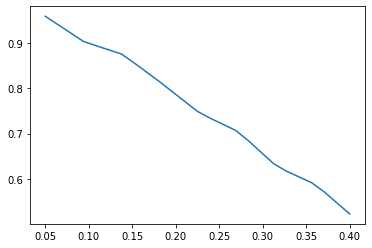

In [11]:
def EnergyEstimate(kappa) :
    # Approximate the profile by linear interpolation
    for i, k in enumerate(kappas) :
        if k > kappa : break
    if i <= 0 : return 1
    return means[i-1] + (means[i]-means[i-1]) * (kappa - kappas[i-1]) / (kappas[i] - kappas[i-1])

xx = np.linspace(0.05, 0.4, 25)
yy = [EnergyEstimate(x) for x in xx]
plt.plot(xx, yy)

In [12]:
class QuantumGenerator(nn.Module):
    """Quantum generator class for the patch method"""

    def __init__(self, q_delta=1):
        """
        Args:
            n_generators (int): Number of sub-generators to be used in the patch method.
            q_delta (float, optional): Spread of the random distribution for parameter initialisation.
        """

        super().__init__()

        self.q_params = nn.ParameterList(
            [
                nn.Parameter(q_delta * torch.rand(q_depth * (n_data_qubits+n_anc_qubits)),
                             requires_grad=True),
            ])

    def forward(self, k, z):
        amplitudes = partial_measure(k, z, self.q_params[0])
        image = torch.sqrt(amplitudes*amplitudes.conj())
        image = image.reshape(16, 16)
        return image

In [13]:
generator = QuantumGenerator().to(device)
criterion = nn.MSELoss()

lrG = 0.1
num_iter = 1000

optG = optim.SGD(generator.parameters(), lr=lrG)


In [14]:
kappa = np.random.uniform(0.05, 0.4)
noise = torch.rand(n_data_qubits+n_anc_qubits, device=device) * math.pi / 2
image = generator(kappa, noise)

In [15]:
a = proxy_loss(image)
b = EnergyEstimate(kappa)
c = (a-b)**2
print(a, b, c)

tensor(0.2218+0.j, dtype=torch.complex128, grad_fn=<DivBackward0>) 0.8145342895166228 tensor(0.3513-0.j, dtype=torch.complex128, grad_fn=<PowBackward0>)


In [16]:
for iterations in range(num_iter) :
    kappa = np.random.uniform(0.05, 0.4)
    noise = torch.rand(n_data_qubits+n_anc_qubits, device=device) * math.pi / 2
    
    generator.zero_grad()
    image = generator(kappa, noise)

    loss = proxy_loss(image) # Simulated 
    target = EnergyEstimate(kappa)
    
    mse = (loss - target) ** 2
    mse.backward()
    
    optG.step()

ValueError: Computing the gradient of circuits that return the state is not supported.